## Environment

In [91]:
import numpy as np

In [92]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [93]:
a = np.random.multinomial(1,[1/5.]*5)
print(a)
print(np.argmax(a))

[1 0 0 0 0]
0


In [94]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

In [95]:
class CyclicEnvironment(Environment):

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,phase):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.phase = phase                                              # phase vector (size: 365)
    self.day = 0                                                    # day counter

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[self.phase[self.day],pulled_price])                         # number of people that buy once they clicked
    return reward_price

  def day_round(self):
    self.day += 1

In [96]:
class NonStationnary(Environment):
  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,
              time_abrupt_change_1, time_abrupt_change_2):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.time_abrupt_change_1 = time_abrupt_change_1
    self.time_abrupt_change_2 = time_abrupt_change_2
    #n_phases = len(self.probabilities)
    #self.phases_size = bids/n_phases
  def pricing_round(self, pulled_price):
    print("Error: Non-stationnary environment needs the time to know the conversion rates!")
    return float("NaN")

  def pricing_round(self, pulled_price, time):
    if time < self.time_abrupt_change_1:
      reward_price = np.random.binomial(1,self.probabilities[0,pulled_price])
    elif time < self.time_abrupt_change_2:
      reward_price = np.random.binomial(1,self.probabilities[1,pulled_price])
    else:
      reward_price = np.random.binomial(1,self.probabilities[2,pulled_price])
    return reward_price


## Pricing

In [97]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [98]:
class Exp3_Pricing_Learner(Learner):
  def __init__(self,n_arms,prices, gamma=0.2):
    super().__init__(n_arms)                    # number of prices
    self.gamma = gamma                          # exploration parameter
    self.prices = prices                        # prices (array)
    self.weights = np.ones(len(prices))         # weights parameter
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/self.n_arms for i in range(self.n_arms)])

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    idx = np.random.choice([0,1,2,3,4], p=self.p)
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    est_reward = reward*self.prices[pulled_arm]/self.p[pulled_arm]/np.max(self.prices)
    self.weights[pulled_arm] = self.weights[pulled_arm]*np.exp(self.gamma*est_reward/len(self.prices))
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/self.n_arms for i in range(self.n_arms)])

  def debug(self):
    print(self.p, self.weights)

In [99]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms, prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

In [100]:
class CUSUM():
    def __init__(self, M, eps, h):
        self.M = M #used to compute reference point
        self.eps = eps
        self.h = h #treshold
        self.t = 0
        self.reference = 0
        self.g_plus = 0
        self.g_minus = 0

    def update (self, sample):   #compute mean before we reach M (not enough samples), after we compute variables
        self.t += 1
        if self.t <= self.M:
            self.reference += sample/self.M
            return 0
        else:
            s_plus = (sample - self .reference) - self.eps
            s_minus = - (sample - self.reference) - self.eps
            self.g_plus = max(0, self.g_plus + s_plus)
            self.g_minus = max(0, self .g_minus + s_minus)
            return self.g_plus > self.h or self.g_minus > self.h
    def reset (self):    #resets when a change is detected
        self.t = 0
        self.g_plus = 0
        self.g_minus = 0

In [101]:
class CUSUM_UCB_Pricing_Learner(UCB_Pricing_Learner) :
    def __init__(self, n_arms, prices, M=100, eps=0.05, h=20, alpha=0.1):
        super().__init__(n_arms, prices)
        self.change_detection = [CUSUM(M, eps, h) for _ in range (n_arms)]
        self.valid_rewards_per_arm = [[] for _ in range (n_arms)]  #keeps all rewards that we have got after last CD
        self.detections = [[] for _ in range (n_arms)] #time of detection per arm
        self.alpha = alpha  #prob of taking a non optimal arm

    def pull_arm(self):
        if np.random.binomial (1, 1-self.alpha):
            upper_bound = self.empirical_means + self.confidence
            upper_bound [np.isinf (upper_bound)] = 1e9 #avoiding inf case
            pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
#             print(pulled_arm)
            return pulled_arm
        else:
            pulled_arm = np.random.randint(0, self.n_arms)
#             print(pulled_arm)
            return pulled_arm

    def update(self, pulled_arm, reward):
        self.t += 1
        if self.change_detection[pulled_arm].update(reward):
#             print("change_detected at time:")
#             print(self.t)
#             print("on arm:")
#             print(pulled_arm)
            self.detections[pulled_arm].append (self.t)
            self.valid_rewards_per_arm[pulled_arm] =[]
            self.change_detection[pulled_arm].reset()
        self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
        self.empirical_means[pulled_arm] = np.mean(self.valid_rewards_per_arm[pulled_arm])
        total_valid_samples = sum([len(x) for x in self.valid_rewards_per_arm])
        for a in range (self.n_arms):
            n_samples = len(self.valid_rewards_per_arm[a])
            self.confidence[a] = (2*np.log(total_valid_samples)/n_samples)**0.5 if n_samples > 0 else np.inf

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.valid_rewards_per_arm [pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)

    def total_numofchanges(self):
        numchanges = 0
        for i in range (self.n_arms):
            numchanges += len(self.detections[i])
        return numchanges

In [102]:
class SW_UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices, tau):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)
    self.tau = tau                                        # parameter for the confidence bound
    self.arm_window = []                                  # window of the last arms played
    self.nb_w_samples_per_arm = [0 for _ in range(n_arms)] # number of samples in each arm window
    self.last_reward_arm_out = -1                         # last arm that went out of the arm window

  def empirical_means_in_range(self, pulled_arm):
    count = self.nb_w_samples_per_arm[pulled_arm]
    return sum(self.rewards_per_arm[pulled_arm])/count if count > 0 else 1e3

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t

    for a in range(self.n_arms):
      if self.nb_w_samples_per_arm[a] == 0:
        return a

    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update_observations(self, pulled_arm, reward):
    self.arm_window.append(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.nb_w_samples_per_arm[pulled_arm] += 1
    if self.t > self.tau:
      self.last_reward_arm_out = self.arm_window.pop(0)
      self.rewards_per_arm[self.last_reward_arm_out].pop(0)
      self.nb_w_samples_per_arm[self.last_reward_arm_out] -= 1

    self.collected_rewards = np.append(self.collected_rewards,reward)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
#     print(self.nb_w_samples_per_arm)
#     print(sum(self.nb_w_samples_per_arm))
    self.empirical_means[pulled_arm] = self.empirical_means_in_range(pulled_arm)
    # keep update the empirical means of the last arm that went out of the arm window
    if (self.last_reward_arm_out != -1):
      self.empirical_means[self.last_reward_arm_out] = self.empirical_means_in_range(self.last_reward_arm_out)
    for a in range(self.n_arms):
      nb_samples_t_1_tau = self.nb_w_samples_per_arm[a]
      if (a == pulled_arm):
        nb_samples_t_1_tau -= 1
      if (a == self.last_reward_arm_out):
        nb_samples_t_1_tau += 1
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/nb_samples_t_1_tau) if nb_samples_t_1_tau > 0 else 1e3

## Simulation

In [103]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [104]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.36,0.3,0.257,0.313,0.2],
              [0.5,0.3,0.257,0.225,0.2],
              [0.36,0.3,0.257,0.225,0.278],
              [0.36,0.416,0.257,0.225,0.2],
              [0.36,0.3,0.357,0.225,0.2]])

opt_rate = np.array([])
for i in range(p.shape[0]):
  opt = p[i,:][np.argmax(p[i,:]*prices)]
  opt_rate = np.append(opt_rate,opt)
  print("Phase " + str(i+1) + ":")
  print("idx: " + str(np.argmax(p[i,:]*prices)) + "  price: " + str(prices[np.argmax(p[i,:]*prices)]) + "  rate: " + str(opt) + "  price*rate: " + str(opt*prices[np.argmax(p[i,:]*prices)]))
  print("")

Phase 1:
idx: 3  price: 8  rate: 0.313  price*rate: 2.504

Phase 2:
idx: 0  price: 5  rate: 0.5  price*rate: 2.5

Phase 3:
idx: 4  price: 9  rate: 0.278  price*rate: 2.5020000000000002

Phase 4:
idx: 1  price: 6  rate: 0.416  price*rate: 2.496

Phase 5:
idx: 2  price: 7  rate: 0.357  price*rate: 2.4989999999999997



Advertising (optimal bid):
idx: 64  bid: 0.6464646464646465  clicks-costs: 6.719849791582364


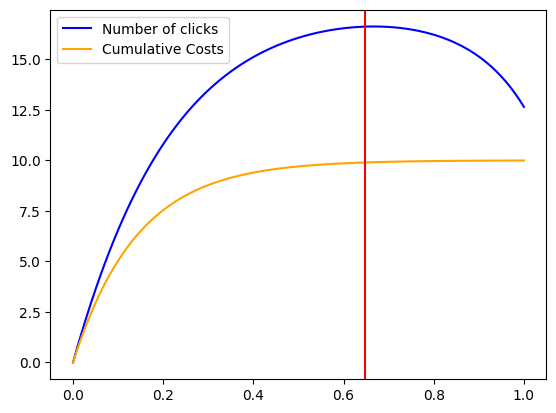

In [105]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 20 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 10 * (1.0 - np.exp(-7*x))
opt_bid_ind = np.argmax(clicks(bids)-costs(bids))
plt.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
plt.legend(["Number of clicks", "Cumulative Costs"])
plt.axvline(bids[opt_bid_ind],c='red')
print("Advertising (optimal bid):")
print("idx: " + str(opt_bid_ind) + "  bid: " + str(bids[opt_bid_ind]) + "  clicks-costs: " + str(clicks(bids[opt_bid_ind])-costs(bids[opt_bid_ind])))

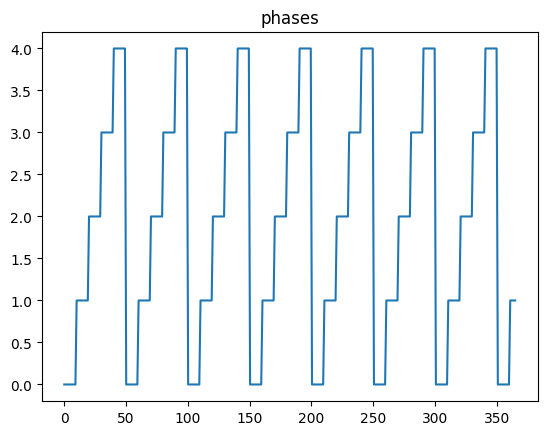

In [106]:
# Non stationarity: cyclic frequent changes
phase = []
change_rate = 10
ind = -1
for i in range(365):
  if not i%change_rate:
    ind = ind+1
    a = ind%5
  phase.append(a)

t = np.linspace(0,365,365)
plt.plot(t,phase)
plt.title("phases")

opt=np.array([])
for i in phase:
  opt = np.append(opt,opt_rate[i]*prices[np.argmax(p[i,:]*prices)]*clicks(bids[opt_bid_ind]) - costs(bids[opt_bid_ind]))


## Part 6.2

In [107]:
time_abrupt_change_1 = 92
time_abrupt_change_2 = 92+15

In [124]:
# variables for EXP3 algorithm
gamma = 0.1
# variables for CUSUM algorithm
M = 105
eps = 0.0771886247934499
h = 8.901757699412148
alpha = 0.002830372497030649

tau = 9223

# experiments
n_experiments = 100

exp3_rewards_per_experiment = []
cusum_rewards_per_experiment = []
sw_ucb_rewards_per_experiment = []

phase_tracker_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = CyclicEnvironment(n_arms = n_prices,
                          probabilities = p,
                          bids = bids,
                          average_number_of_clicks = clicks,
                          average_cum_daily_cost = costs,
                          noise_clicks = sigma_clicks,
                          noise_cost = sigma_costs,
                          phase = phase)

  exp3_learner = Exp3_Pricing_Learner(n_arms = n_prices,
                                      prices = prices,
                                      gamma=gamma)
  cusum_learner = CUSUM_UCB_Pricing_Learner (n_arms = n_prices, prices = prices, M = M, eps=eps, h=h, alpha=alpha)
  sw_ucb_learner = SW_UCB_Pricing_Learner(n_prices, prices, tau)


  exp3_collected_costs = np.array([])
  cusum_collected_costs = np.array([])
  sw_ucb_collected_costs = np.array([])

  exp3_daily_pricing_reward = np.array([])
  cusum_daily_pricing_reward = np.array([])
  sw_ucb_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # Exp3
    pulled_bid = opt_bid_ind # 64
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    exp3_collected_costs = np.append(exp3_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = exp3_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      exp3_learner.update(pulled_price, reward_price)
    exp3_daily_pricing_reward = np.append(exp3_daily_pricing_reward,(reward_click>0)*np.sum(exp3_learner.collected_rewards[-reward_click:]))

    # CUSUM
    pulled_bid = opt_bid_ind
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = cusum_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      cusum_learner.update(pulled_price, reward_price)
    cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,
                                           (reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))

    # SW
    pulled_bid = opt_bid_ind
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    sw_ucb_collected_costs = np.append(sw_ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = sw_ucb_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      sw_ucb_learner.update(pulled_price, reward_price)
    sw_ucb_daily_pricing_reward = np.append(sw_ucb_daily_pricing_reward,
                                           (reward_click>0)*np.sum(sw_ucb_learner.collected_rewards[-reward_click:]))



    env.day_round()
  #exp3_learner.debug()
  exp3_rewards_per_experiment.append(exp3_daily_pricing_reward - exp3_collected_costs)
  cusum_rewards_per_experiment.append(cusum_daily_pricing_reward - cusum_collected_costs)
  sw_ucb_rewards_per_experiment.append(sw_ucb_daily_pricing_reward - sw_ucb_collected_costs)

100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


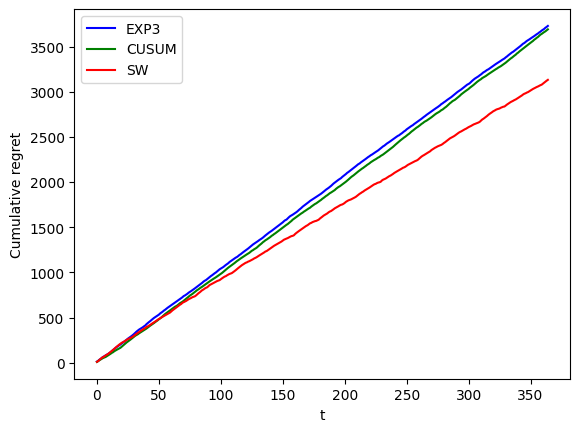

In [125]:
plt.figure(0)
plt.ylabel("Cumulative regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - exp3_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cusum_rewards_per_experiment, axis = 0)), 'g')
plt.plot(np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment, axis = 0)), 'r')


# time = range(0, T)
# cusum_std = np.std(np.cumsum(opt - cusum_rewards_per_experiment, axis=1), axis=0)
# cusum_metric= np.mean(np.cumsum(opt - cusum_rewards_per_experiment, axis=1), axis=0)
# plt.fill(np.concatenate([time, time[::-1]]),
#          np.concatenate([cusum_metric - cusum_std, (cusum_metric + cusum_std)[::-1]]),
#          alpha=.5, fc='g', ec=None, label='standard deviation')

# time = range(0, T)
# sw_ucb_std = np.std(np.cumsum(opt - sw_ucb_rewards_per_experiment, axis=1), axis=0)
# sw_ucb_metric= np.mean(np.cumsum(opt - sw_ucb_rewards_per_experiment, axis=1), axis=0)
# plt.fill(np.concatenate([time, time[::-1]]),
#          np.concatenate([sw_ucb_metric - sw_ucb_std, (sw_ucb_metric + sw_ucb_std)[::-1]]),
#          alpha=.5, fc='r', ec=None, label='standard deviation')


plt.legend(["EXP3", "CUSUM","SW"])